# Denoising mRNA

In this tutorial, we'll be walking through the steps to denoising mRNA counts in a species-mixing data.   

In this experiment, an equal number of human HEK293T cells and mouse NIH3T3 cells were pooled and sequenced, transcripts from the other organism were unambiguously ambient contamination. The original dataset is downloaded from 10x genomics [dataset](https://www.10xgenomics.com/resources/datasets/20-k-1-1-mixture-of-human-hek-293-t-and-mouse-nih-3-t-3-cells-3-ht-v-3-1-3-1-high-6-1-0), and cell annotation file is available at  [scAR-reproducibility/data](https://github.com/CaibinSh/scAR-reproducibility/tree/main/data)

<div class="alert alert-info">

Note

You need to install [scar](https://scar-tutorials.readthedocs.io/en/latest/) to run this notebook on your own device. 

You can also run it on Colab [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Novartis/scAR/blob/main/docs/tutorials/scAR_tutorial_mRNA_denoising.ipynb)

</div>

In [ ]:
# Run this cell to install scar in Colab
# Skip this cell if running on your own device

%pip install scanpy
%pip install git+https://github.com/Novartis/scAR.git
%pip install matplotlib==3.1.3  # Specify this matplotlib version to avoid errors

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from scar import model

import warnings
warnings.simplefilter("ignore")

## Download data

The raw and filtered count matrices can be downloaded from 10x Dataset.

### The raw data

cellranger output: raw_feature_bc_matrix

In [2]:
hgmm_20k_raw = sc.read_10x_h5(filename='20k_hgmm_3p_HT_nextgem_Chromium_X_raw_feature_bc_matrix.h5ad',
                                 backup_url='https://cf.10xgenomics.com/samples/cell-exp/6.1.0/20k_hgmm_3p_HT_nextgem_Chromium_X/20k_hgmm_3p_HT_nextgem_Chromium_X_raw_feature_bc_matrix.h5');
hgmm_20k_raw.var_names_make_unique();

### The filtered data

cellranger output: filtered_feature_bc_matrix

In [3]:
hgmm_20k = sc.read_10x_h5(filename='20k_hgmm_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.h5ad',
                             backup_url='https://cf.10xgenomics.com/samples/cell-exp/6.1.0/20k_hgmm_3p_HT_nextgem_Chromium_X/20k_hgmm_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.h5');
hgmm_20k.var_names_make_unique();

### Annotation and filtering

We annotated cells by their cell species and provided the annotation file

In [4]:
!git clone https://github.com/CaibinSh/scAR-reproducibility.git

hgmm_20k_anno = pd.read_csv('scAR-reproducibility/data/20k_hgmm_cell_annotation.csv', index_col=0) 
hgmm_20k.obs=hgmm_20k.obs.join(hgmm_20k_anno[['species']])

fatal: destination path 'scAR-reproducibility' already exists and is not an empty directory.


Gene and cell filtering

In [5]:
sc.pp.filter_genes(hgmm_20k, min_counts=200);
sc.pp.filter_genes(hgmm_20k, max_counts=6000);
sc.pp.filter_cells(hgmm_20k, min_genes=200);

Calculate number of human and mouse transcripts

In [6]:
hgmm_20k.obs['human gene counts'] = hgmm_20k[:, hgmm_20k.var['genome']=="GRCh38"].X.sum(axis=1).A1
hgmm_20k.obs['mouse gene counts'] = hgmm_20k[:, hgmm_20k.var['genome']=="mm10"].X.sum(axis=1).A1

In [7]:
hgmm_20k

AnnData object with n_obs × n_vars = 16292 × 16586
    obs: 'species', 'n_genes', 'human gene counts', 'mouse gene counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'

### Raw count matrix

Get a dataframe of raw count as the input of `scar`

In [8]:
raw_counts = hgmm_20k.to_df()
raw_counts.head()

,GRCh38_AL627309.5,GRCh38_LINC01128,GRCh38_LINC00115,GRCh38_FAM41C,GRCh38_AL645608.2,GRCh38_LINC02593,GRCh38_SAMD11,GRCh38_KLHL17,GRCh38_AL645608.7,GRCh38_ISG15,...,mm10___Gm21887,mm10___Kdm5d,mm10___Eif2s3y,mm10___Uty,mm10___Ddx3y,mm10___AC133103.1,mm10___AC168977.1,mm10___CAAA01118383.1,mm10___Spry3,mm10___Tmlhe
AAACCCAAGAGCCGAT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGCGTTCCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGTGCGTCC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCACAAACTGCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCACAATACCTG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Estimate ambient profile

### Identify cell-free droplets

We use a kneeplot to identify subpopulations of raw droplets, these include cell-containing, cell-free droplets and other droplets

In [9]:
all_droplets = pd.DataFrame(hgmm_20k_raw.X.sum(axis=1), index = hgmm_20k_raw.obs_names, columns=['total_counts'])

all_droplets['droplets'] = 'cell-free droplets'
all_droplets['droplets'] = all_droplets['droplets'].mask(all_droplets['total_counts']>12, 'droplet II')
all_droplets['droplets'] = all_droplets['droplets'].mask(all_droplets['total_counts']>40, 'droplet I')
all_droplets['droplets'] = all_droplets['droplets'].mask(all_droplets.index.isin(hgmm_20k.obs_names), 'cells')
all_droplets = all_droplets.sort_values(by='total_counts', ascending=False).reset_index().rename_axis("rank").reset_index()
all_droplets = all_droplets.loc[all_droplets['total_counts']>0]
all_droplets = all_droplets.set_index('index').rename_axis('cells')

<div class="alert alert-info">

Note

The thresholds (12 and 40) are experiment-specific. We currently manually determine them by examing the following kneeplot. 

</div>

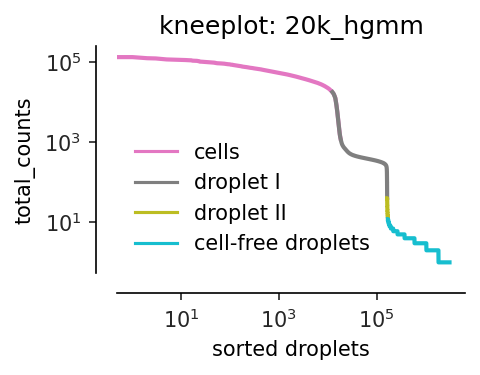

In [10]:
plt.figure(figsize=(3, 2), dpi=150)

ax = sns.lineplot(data = all_droplets,
                  x='rank',
                  y='total_counts',
                  hue='droplets',
                  hue_order=['cells', 'droplet I', 'droplet II', 'cell-free droplets'],
                  palette=sns.color_palette()[-4:],
                  markers=False,
                  lw=2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('sorted droplets');
ax.legend(loc='lower left', ncol=1, title=None, frameon=False)
ax.set_title(f'kneeplot: 20k_hgmm')

sns.set_palette("muted")
sns.set_style("ticks")
sns.despine(offset=10, trim=False);

### Average cell-free droplets

We calculated ambient profile from the subpopulation of 'cell-free droplets'

In [11]:
cell_free = hgmm_20k_raw[hgmm_20k_raw.obs_names.isin(all_droplets[all_droplets['droplets']=='cell-free droplets'].index)]

cell_free = cell_free[:, hgmm_20k.var_names]

# average and normalize the transcript in cell-free droplets.
ambient_profile = pd.DataFrame((cell_free.X.sum(axis=0)/cell_free.X.sum()).A1, index = hgmm_20k.var_names, columns = ['ambient profile'])

ambient_profile.head()

,ambient profile
GRCh38_AL627309.5,0.000006
GRCh38_LINC01128,0.000086
GRCh38_LINC00115,0.000015
GRCh38_FAM41C,0.000017
GRCh38_AL645608.2,0.000015


## Training

<div class="alert alert-info">

Note

In this particular case, we need to set a high sparsity parameter, because the mRNA matrix contains both human and mouse transcripts. The data is sparser than ordinary cases which contains single-genome transcripts.

</div>

In [12]:
hgmm_20k_scar = model(raw_count = raw_counts,
                      ambient_profile = ambient_profile, # In the case of default None, the ambient_profile will be calculated by averaging pooled cells
                      feature_type='mRNA',
                      sparsity=1,
                     )

hgmm_20k_scar.train(epochs=400,
                    batch_size=64,
                    verbose=True
                   )

# After training, we can infer the native true signal
hgmm_20k_scar.inference()  # by defaut, batch_size = None, set a batch_size if getting a GPU memory issue

..Running VAE using the following param set:
......denoised count type:  mRNA
......count model:  binomial
......num_input_feature:  16586
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
100%|██████████| 400/400 [12:57<00:00,  1.94s/it]
  Inferring .....


The denoised counts are saved in `hgmm_20k_scar.native_counts` and can be used for downstream analysis.

In [13]:
denoised_count = pd.DataFrame(hgmm_20k_scar.native_counts, index=raw_counts.index, columns=raw_counts.columns)

denoised_count.head()

,GRCh38_AL627309.5,GRCh38_LINC01128,GRCh38_LINC00115,GRCh38_FAM41C,GRCh38_AL645608.2,GRCh38_LINC02593,GRCh38_SAMD11,GRCh38_KLHL17,GRCh38_AL645608.7,GRCh38_ISG15,...,mm10___Gm21887,mm10___Kdm5d,mm10___Eif2s3y,mm10___Uty,mm10___Ddx3y,mm10___AC133103.1,mm10___AC168977.1,mm10___CAAA01118383.1,mm10___Spry3,mm10___Tmlhe
AAACCCAAGAGCCGAT-1,0.017586,0.305345,0.009403,0.079865,0.022414,0.129903,0.530398,0.092016,0.130670,0.410815,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AAACCCAAGCGTTCCG-1,0.028123,0.300129,0.046148,0.022735,0.060199,0.121265,0.652807,0.118856,0.231104,0.416823,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AAACCCAAGTGCGTCC-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.073836,0.171912,0.771821,0.259909,1.721138,0.000000,0.000000,0.217245,0.095209,0.059166
AAACCCACAAACTGCT-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001662,0.000000,0.000000,0.000000,0.000000,0.082865,0.060749,0.141865,0.101782,0.065129
AAACCCACAATACCTG-1,0.071757,0.509049,0.095091,0.060625,0.136401,0.215216,0.686515,0.177997,0.508158,0.778697,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Visualization

Calculate number of human and mouse transcripts before denoising

In [14]:
raw_counts_df = hgmm_20k.obs[['human gene counts', 'mouse gene counts']].astype(int)
raw_counts_df['log2(human gene counts+1)'] = np.log2(raw_counts_df['human gene counts']+1)
raw_counts_df['log2(mouse gene counts+1)'] = np.log2(raw_counts_df['mouse gene counts']+1)
raw_counts_df = raw_counts_df.join(hgmm_20k.obs[['species']])

visualization of raw counts

<Figure size 600x600 with 0 Axes>

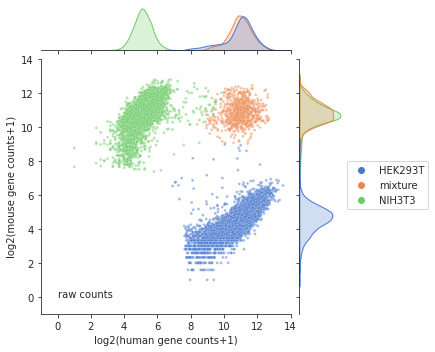

In [15]:
plt.figure(figsize=(4, 4), dpi=150)

ax = sns.jointplot(data=raw_counts_df,
                   x="log2(human gene counts+1)",
                   y="log2(mouse gene counts+1)",
                   hue='species',
                   hue_order=['HEK293T', 'mixture', 'NIH3T3'],
                   s=8,
                   alpha=0.5,
                   legend=True,
                   height=5,
                   marginal_kws={'common_norm':False});
ax.ax_joint.text(0, 0, 'raw counts')
ax.ax_joint.set_xlim(-1, 14)
ax.ax_joint.set_ylim(-1, 14)
ax.ax_joint.legend(bbox_to_anchor=(1.55, 0.6),borderaxespad=0);

Calculate number of human and mouse transcripts after denoising

In [16]:
denoised_count['human gene counts'] = denoised_count.loc[:,denoised_count.columns.str.startswith('GRCh38_')].sum(axis=1)
denoised_count['mouse gene counts'] = denoised_count.loc[:,denoised_count.columns.str.startswith('mm10_')].sum(axis=1)
denoised_count['species'] = raw_counts_df['species']
denoised_count['log2(human gene counts+1)'] = np.log2(denoised_count['human gene counts']+1)
denoised_count['log2(mouse gene counts+1)'] = np.log2(denoised_count['mouse gene counts']+1)

visualization of denoised counts

<Figure size 600x600 with 0 Axes>

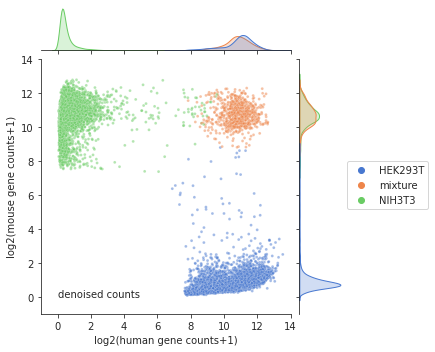

In [17]:
plt.figure(figsize=(4, 4), dpi=150);

ax = sns.jointplot(data=denoised_count,
                   x="log2(human gene counts+1)",
                   y="log2(mouse gene counts+1)",
                   hue='species',
                   hue_order=['HEK293T', 'mixture', 'NIH3T3'],
                   s=8,
                   alpha=0.5,
                   legend=True,
                   height=5,
                   marginal_kws={'common_norm':False});
ax.ax_joint.text(0, 0, 'denoised counts')
ax.ax_joint.set_xlim(-1, 14)
ax.ax_joint.set_ylim(-1, 14)
ax.ax_joint.legend(bbox_to_anchor=(1.55, 0.6),borderaxespad=0);